### *In this notebook we conduct analysis on real estate listing data in Philadlphia, PA for current listings and listings from January 2019 to February 2020. The purpose is to learn if there is a significant difference between the mean listing prices for the two datasets and ultimately determine if the COVID-19 pandemic has negatively effected the real estate market. Later in the analysis we look closer specifically at zip codes that were most and least effected by COVID-19. "Most" and "least" effected for this analysis is in reference to the number positive COVID-19 cases.

#### Analysis: Lawrence Love
#### COVID-19 Data via opendataphilly.org API: Lawrence Love
#### Historical Data via rapidapi.com: Frank Zhao
#### Current Data via rapidapi.com: Jason Li

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import re
import json
import requests
from scipy import stats
import statsmodels.stats.api as sms
style.use('ggplot')

## Current Listing Data

In [2]:
curr_df = pd.read_csv('./update_df.csv')

In [3]:
curr_df[:3]

,property_id,prop_type,prop_sub_type,prop_status,price,baths_full,baths,beds,last_update,photo_count,...,state_code,county,lat,lon,neighborhood_name,buiding_size(sqft),lot_size(sqft),agent_id,agent_name,brand_name
0,M4046594895,condo,duplex_triplex,for_sale,249900,3.0,3,6.0,2020-10-13T17:54:05Z,9,...,PA,Philadelphia,39.974408,-75.243700,West Philadelphia,1632.0,1842.0,1291281.0,Ausra Anusauskas,Archstone Realty
1,M3939384476,condo,townhomes,for_sale,116800,1.0,1,3.0,2020-10-13T18:18:18Z,7,...,PA,Philadelphia,39.926283,-75.225382,Southwest Philadelphia,1092.0,992.0,347285.0,Dr Hanh Vo,Vihi Realty
2,M4036371277,condo,townhomes,for_sale,215000,1.0,2,3.0,2020-10-13T17:24:20Z,35,...,PA,Philadelphia,40.039721,-75.142100,Upper North District,1360.0,1501.0,NaN,Kevin Chen,Premium Realty Castor Inc


In [4]:
curr_df.rename(columns = {'postal_code':'zip_code'}, inplace=True)

## Historical Listing Data

In [5]:
hist_df = pd.read_csv('./hist_price_with_zip.csv')

In [6]:
hist_df.head()

,property_id,event_name,date,price,price_range_min,price_range_max,price_changed,sqft,datasource_name,source,listing,iso_date,listing_id,previous_event_price,postal_code
0,M3392201642,Price Changed,2020-10-17T17:00:00Z,355000,NaN,NaN,5000,1750,BrightMLS,MLS #PAPH935838,NaN,NaN,NaN,NaN,19116
1,M3392201642,Listed,2020-10-11T17:00:00Z,350000,NaN,NaN,0,1750,BrightMLS,MLS #PAPH935838,NaN,NaN,NaN,NaN,19116
2,M3164904583,Listed,2020-10-11T17:00:00Z,149900,NaN,NaN,0,1176,BrightMLS,MLS #PAPH944164,NaN,NaN,NaN,NaN,19143
3,M3164904583,Sold,2002-03-18T17:00:00Z,70500,NaN,NaN,0,1176,NaN,Public Record,NaN,NaN,NaN,NaN,19143
4,M3164904583,Sold,1988-09-21T17:00:00Z,33900,NaN,NaN,0,1176,NaN,Public Record,NaN,NaN,NaN,NaN,19143


In [7]:
# Remove 'T00:00:00Z' from 'date'
hist_df['date'] =  [re.sub('T(.*?)Z','', str(x)) for x in hist_df['date']]

In [8]:
# Covnert 'date' to a datetime object
hist_df['date'] = pd.to_datetime(hist_df['date'])

In [9]:
hist_df.rename(columns = {'postal_code':'zip_code'}, inplace=True)

### Subset properties listed from January 2019 - February 2020

In [10]:
hist_19 = hist_df[hist_df['date'].isin(pd.date_range(start='2019-01-01', end='2020-02-29'))]

In [11]:
print('length of full hist_df =', len(hist_df))
print('length of df subset for January 2019 - February 2020 =', len(hist_19))
print('So we lose %d instsances after subsetting' % (len(hist_df) - len(hist_19)))

length of full hist_df = 60459
length of df subset for January 2019 - February 2020 = 5728
So we lose 54731 instsances after subsetting


### Drop the extra listing data, keep the most recent listing.

In [12]:
final_hist = hist_19.sort_values('date').drop_duplicates('property_id',keep='last')

In [13]:
print('After keeping only the last listed piece of data for each property')
print('in our final historical dataset, we are left with', len(final_hist['zip_code']), 'instances.')
print('The dataset for the current listings has', len(curr_df), 'instances.')

After keeping only the last listed piece of data for each property
in our final historical dataset, we are left with 2493 instances.
The dataset for the current listings has 9562 instances.


## Test outcomes by zip

In [14]:
url = 'https://phl.carto.com/api/v2/sql?q=SELECT * FROM covid_cases_by_zip'
response = requests.request("GET", url)
test_zip = pd.json_normalize(response.json()['rows'])

In [15]:
test_zip.head()

,cartodb_id,the_geom,the_geom_webmercator,covid_status,zip_code,count,etl_timestamp
0,1,None,None,NEG,19140,19469,2020-11-14T18:20:01Z
1,2,None,None,POS,19127,118,2020-11-14T18:20:01Z
2,3,None,None,NEG,19133,8540,2020-11-14T18:20:01Z
3,4,None,None,POS,19146,1090,2020-11-14T18:20:01Z
4,5,None,None,NEG,19138,12124,2020-11-14T18:20:01Z


In [16]:
# Subset for positive tests
pos_zip = test_zip[test_zip['covid_status'] == 'POS']

In [17]:
pos_zip.sort_values('count', ascending=False).head()

,cartodb_id,the_geom,the_geom_webmercator,covid_status,zip_code,count,etl_timestamp
113,114,None,None,POS,19120,2573,2020-11-14T18:20:01Z
13,14,None,None,POS,19124,2540,2020-11-14T18:20:01Z
77,78,None,None,POS,19111,2435,2020-11-14T18:20:01Z
49,50,None,None,POS,19140,2106,2020-11-14T18:20:01Z
108,109,None,None,POS,19143,2035,2020-11-14T18:20:01Z


### Subset the zip codes with the top 10 highest number of positive case counts, and bottom 10 lowest number of positive case counts.

In [18]:
# Top 10 zips by count
top_10_zips = []

for i in pos_zip.sort_values('count', ascending=False)[:10]['zip_code']:
    top_10_zips.append(i)

In [19]:
# Bottom 10 zips by count
bottom_10_zips = []

for i in pos_zip.sort_values('count', ascending=False)[-10:]['zip_code']:
    bottom_10_zips.append(i)

In [20]:
top10_hist = final_hist[final_hist['zip_code'].isin(top_10_zips)]
bot10_hist = final_hist[final_hist['zip_code'].isin(bottom_10_zips)]

In [21]:
top10_curr = curr_df[curr_df['zip_code'].isin(top_10_zips)]
bot10_curr = curr_df[curr_df['zip_code'].isin(bottom_10_zips)]

# Statistical analysis on full datasets, and on datasets with some outliers removed.

### Boxplots - Full Datasets

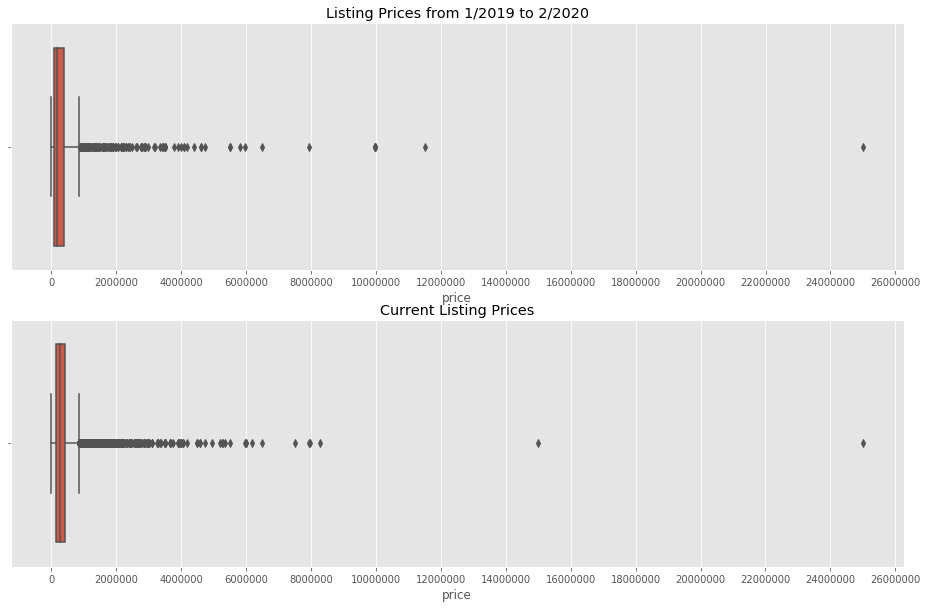

In [22]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(16)
ax = fig.add_subplot(2, 1, 1)
final_hist_prices_plot = sns.boxplot(final_hist['price'], ax=ax)
final_hist_prices_plot.set_title('Listing Prices from 1/2019 to 2/2020')
final_hist_prices_plot.ticklabel_format(style='plain', axis='x')
final_hist_prices_plot.set(xticks=np.arange(0, 26000001, 2000000))
ax = fig.add_subplot(2, 1, 2)
curr_prices_plot = sns.boxplot(curr_df['price'], ax=ax)
curr_prices_plot.set_title('Current Listing Prices')
curr_prices_plot.ticklabel_format(style='plain', axis='x')
curr_prices_plot.set(xticks=np.arange(0, 26000001, 2000000))
plt.show()

### Histograms - Full Datasets

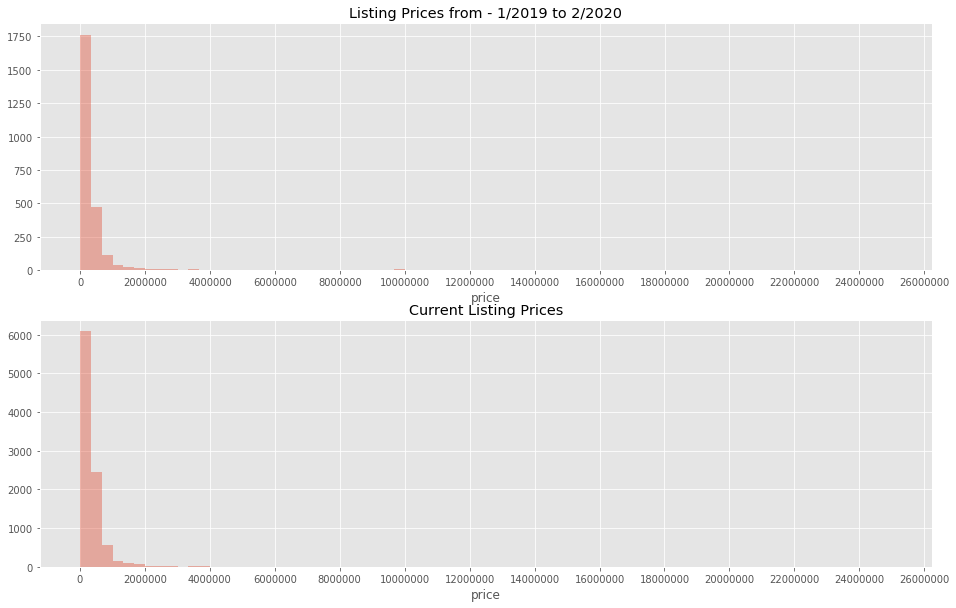

In [23]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(16)
ax = fig.add_subplot(2, 1, 1)
hist_prices_histo = sns.distplot(final_hist['price'], kde=False, bins=75)
hist_prices_histo.set_title('Listing Prices from - 1/2019 to 2/2020')
hist_prices_histo.set(xticks=np.arange(0, 26000001, 2000000))
hist_prices_histo.ticklabel_format(style='plain', axis='x')
ax = fig.add_subplot(2, 1, 2)
curr_prices_histo = sns.distplot(curr_df['price'], kde=False, bins=75)
curr_prices_histo.set_title('Current Listing Prices')
curr_prices_histo.set(xticks=np.arange(0, 26000001, 2000000))
curr_prices_histo.ticklabel_format(style='plain', axis='x')
plt.show()

In [24]:
print('Descriptive statistics for the full historical dataset.')
stats.describe(final_hist['price'])

Descriptive statistics for the full historical dataset.


DescribeResult(nobs=2493, minmax=(900, 25000000), mean=381891.5286803049, variance=854534661057.5542, skewness=12.2668021425143, kurtosis=241.80308075608949)

In [25]:
print('Descriptive statistics for the full current dataset.')
stats.describe(curr_df['price'])

Descriptive statistics for the full current dataset.


DescribeResult(nobs=9562, minmax=(6000, 25000000), mean=381703.5611796695, variance=313156718177.5901, skewness=14.452907462413856, kurtosis=469.3509268783856)

#### The above (slightly less obvious) results read as follows:
* nobs - Number of observations
* minmax - Tuple of the lowest price, and highest price
* skewness - A measure of how skewed the data is, perfectly normal distribution would equal zero
* kurtosis - A measure of how high the peak is in reference to its tails. (High kurtosis has long tails with a high peak - values spread far from the mean)

## Do we have equal variance for the full datasets?

In [26]:
print('Bartlett p-value =', stats.bartlett(final_hist['price'], curr_df['price'])[1], '\n')
print('Leven p-value =', stats.levene(final_hist['price'], curr_df['price'])[1], '\n')
print('Flinger p-value =', stats.fligner(final_hist['price'], curr_df['price'], center='mean')[1])

Bartlett p-value = 6.234360610688021e-259 

Leven p-value = 2.41525136944328e-06 

Flinger p-value = 1.659003770280044e-51


#### The small p-value in all three tests tells us that we do not have equal variance between the full datasets.

## Remove outliers in both datasets
* We'll choose to get rid of listings greater than $900,000.

In [27]:
final_hist2 = final_hist[final_hist['price'] < 900000]

In [28]:
curr_df2 = curr_df[curr_df['price'] < 900000]

In [29]:
print('These outliers only accounted for %.2f%% of our historical data and' % (1 - (len(final_hist2)/len(final_hist))))
print('%.2f%% of the current data.' % (1 - (len(curr_df2)/len(curr_df))))

These outliers only accounted for 0.07% of our historical data and
0.06% of the current data.


## Visualizing the data with some outliers removed:

### Boxplots - Outliers Removed

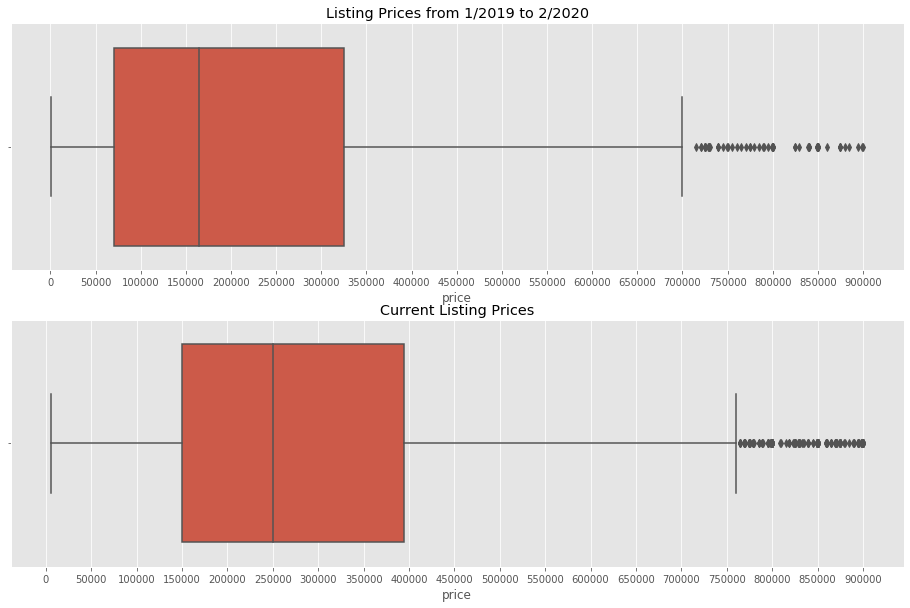

In [30]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(16)
ax = fig.add_subplot(2, 1, 1)
final_hist_prices_plot2 = sns.boxplot(final_hist2['price'], ax=ax)
final_hist_prices_plot2.set_title('Listing Prices from 1/2019 to 2/2020')
final_hist_prices_plot2.ticklabel_format(style='plain', axis='x')
final_hist_prices_plot2.set(xticks=np.arange(0, 900001, 50000))
ax = fig.add_subplot(2, 1, 2)
curr_prices_plot2 = sns.boxplot(curr_df2['price'], ax=ax)
curr_prices_plot2.set_title('Current Listing Prices')
curr_prices_plot2.ticklabel_format(style='plain', axis='x')
curr_prices_plot2.set(xticks=np.arange(0, 900001, 50000))
plt.show()

### Histograms - Outliers Removed

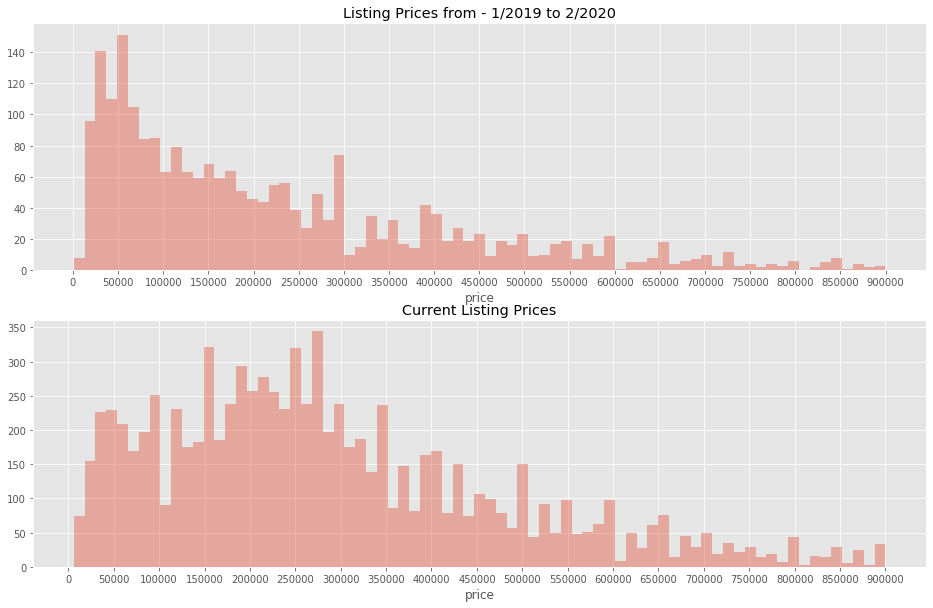

In [31]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(16)
ax = fig.add_subplot(2, 1, 1)
hist_prices_histo2 = sns.distplot(final_hist2['price'], kde=False, bins=75)
hist_prices_histo2.set_title('Listing Prices from - 1/2019 to 2/2020')
hist_prices_histo2.set(xticks=np.arange(0, 900001, 50000))
hist_prices_histo2.ticklabel_format(style='plain', axis='x')
ax = fig.add_subplot(2, 1, 2)
curr_prices_histo2 = sns.distplot(curr_df2['price'], kde=False, bins=75)
curr_prices_histo2.set_title('Current Listing Prices')
curr_prices_histo2.set(xticks=np.arange(0, 900001, 50000))
curr_prices_histo2.ticklabel_format(style='plain', axis='x')
plt.show()

In [32]:
print('Descriptive statistics for the historical data with some outliers removed.')
stats.describe(final_hist2['price'])

Descriptive statistics for the historical data with some outliers removed.


DescribeResult(nobs=2320, minmax=(900, 899900), mean=224190.11422413794, variance=37054673065.41816, skewness=1.1809450478949075, kurtosis=0.8331384196145772)

In [33]:
print('Descriptive statistics for the current data with some outliers removed.')
stats.describe(curr_df2['price'])

Descriptive statistics for the current data with some outliers removed.


DescribeResult(nobs=8984, minmax=(6000, 899999), mean=288463.20102404273, variance=35837855787.81599, skewness=0.8872424310694464, kurtosis=0.4016677938819764)

### Removing some of the outliers has made a clear impact on the skewness and kurtosis measures compared to these measures on the full dataset.

### Do we have equal variance for the datasets with some outliers removed?

In [34]:
print('Bartlett p-value =', stats.bartlett(curr_df2['price'], final_hist2['price'])[1], '\n')
print('Leven p-value =', stats.levene(curr_df2['price'], final_hist2['price'])[1], '\n')
print('Flinger p-value =', stats.fligner(curr_df2['price'], final_hist2['price'], center='mean')[1])

Bartlett p-value = 0.3092113193400671 

Leven p-value = 0.75985958622035 

Flinger p-value = 0.3400303507920644


### All three of the tests for equal varaince have large p-values, which suggests that we do have equal variance for our datasets with some outliers removed.

## Is there a difference between the mean of the historical data and the mean of the current data - with outliers removed?
* Null Hypothesis: The means are equal.
* Alternative Hypothesis: The means are not equal.

In [35]:
tstat, pval = stats.ttest_ind(curr_df2['price'], final_hist2['price'], equal_var=True)
ci = sms.CompareMeans(sms.DescrStatsW(curr_df2['price']), sms.DescrStatsW(final_hist2['price']))
print('p-value =', pval)
print('95% Confidence Interval -', ci.tconfint_diff(usevar='pooled'))

p-value = 2.1435395293392626e-47
95% Confidence Interval - (55601.26424426666, 72944.90935554293)


### *Interpetation:* With 95% confidence, the difference in mean listing price between the historical data and the current data is between 55,601 and 72,945 with the current data having a higher mean listing price. The small p-value tells us that we can reject the null hypothesis that the means are equal, and conclude that this difference in means is statistically significant - the mean listing price before the pandemic is not equal to the mean listing price during the pandemic.

In [36]:
diff = round(stats.describe(curr_df2['price'])[2] - stats.describe(final_hist2['price'])[2],2)
print("The mean of the real estate listings increased by $%d, during the pandemic." % diff)

The mean of the real estate listings increased by $64273, during the pandemic.


### Keep in mind that this increase, 64,273, takes into account the data we have for all of Philadelphia. We know from our COVID data above that some zip codes were hit much harder than others. Let's investigate a little further and see if positive case count might have an impact on mean listing price.

------------------------------

# Statistical analysis on the zip codes with the top 10 highest number of positive cases, and bottom 10 lowest number of positive cases.

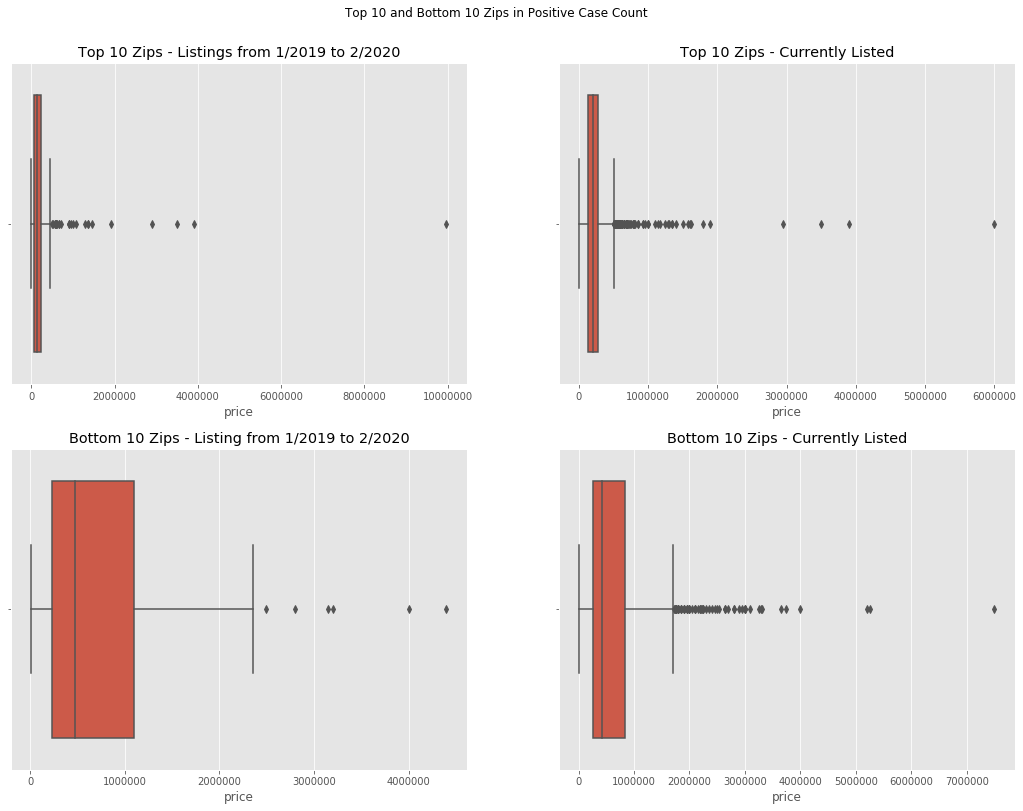

In [37]:
fig = plt.figure()
fig.suptitle("Top 10 and Bottom 10 Zips in Positive Case Count", y=.94)
fig.set_figheight(13)
fig.set_figwidth(18)
ax = fig.add_subplot(2, 2, 1)
top10_hist_prices_plot = sns.boxplot(top10_hist['price'], ax=ax)
top10_hist_prices_plot.set_title('Top 10 Zips - Listings from 1/2019 to 2/2020')
top10_hist_prices_plot.ticklabel_format(style='plain', axis='x')
ax = fig.add_subplot(2, 2, 2)
top10_curr_prices_plot = sns.boxplot(top10_curr['price'], ax=ax)
top10_curr_prices_plot.set_title('Top 10 Zips - Currently Listed')
ax = fig.add_subplot(2, 2, 3)
bot10_hist_prices_plot = sns.boxplot(bot10_hist['price'], ax=ax)
bot10_hist_prices_plot.set_title('Bottom 10 Zips - Listing from 1/2019 to 2/2020')
ax = fig.add_subplot(2, 2, 4)
bot10_curr_prices_plot = sns.boxplot(bot10_curr['price'], ax=ax)
bot10_curr_prices_plot.set_title('Bottom 10 Zips - Currently Listed')
plt.show()

### Our top 10 and bottom 10 data were subset from the previous datasets before outlier removal; we see that these top 10 and bottom 10 subsets also have some outliers to deal with. Our top 10 data seems to have outliers in similar range between the current and historical data, so we'll choose to get rid of listings greater than 600,000 there.

### On the other hand, our bottom 10 data has several outliers in the historical data starting around 2,500,000 up to almost 5,000,000. However, the current data for bottom 10 has several outliers ranging from about 1,750,000 all the way to about 8,000,000! With that said, we'll get rid of all listings with prices greater than 2,500,000 for both current and historical bottom 10 datasets.

In [38]:
top10_hist2 = top10_hist[top10_hist['price'] < 600000]
top10_curr2 = top10_curr[top10_curr['price'] < 600000]
bot10_hist2 = bot10_hist[bot10_hist['price'] < 2500000]
bot10_curr2 = bot10_curr[bot10_curr['price'] < 2500000]

### Now let's see what these plots looks like.

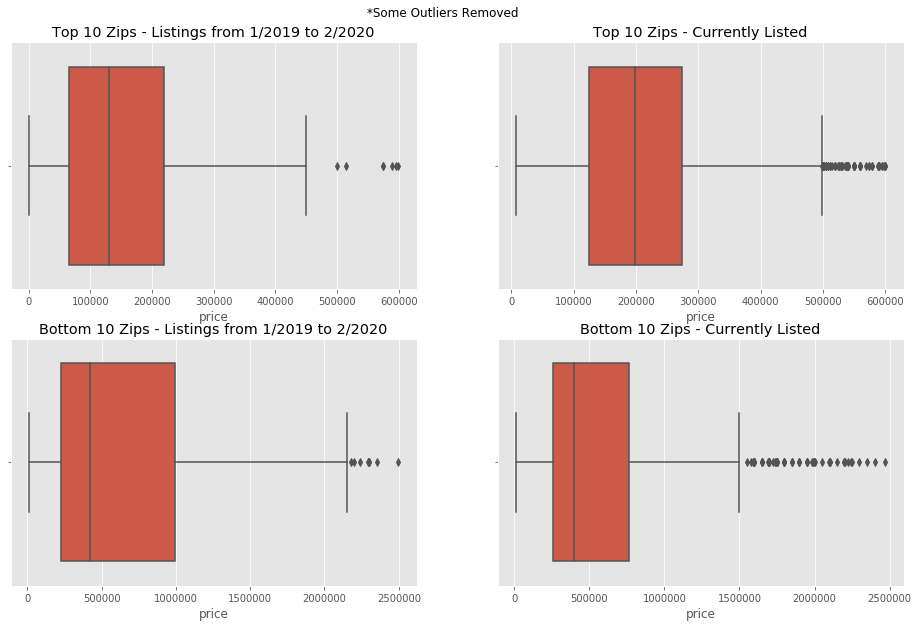

In [39]:
fig = plt.figure()
fig.suptitle("*Some Outliers Removed", y=.93)
fig.set_figheight(10)
fig.set_figwidth(16)
ax = fig.add_subplot(2, 2, 1)
top10_hist2_prices_plot = sns.boxplot(top10_hist2['price'], ax=ax)
top10_hist2_prices_plot.set_title('Top 10 Zips - Listings from 1/2019 to 2/2020')
# top10_hist2_prices_plot.set(xticks=np.arange(0, 500001, 50000))
ax = fig.add_subplot(2, 2, 2)
top10_curr2_prices_plot = sns.boxplot(top10_curr2['price'], ax=ax)
top10_curr2_prices_plot.set_title('Top 10 Zips - Currently Listed')
# top10_curr2_prices_plot.set(xticks=np.arange(0, 500001, 50000))
ax = fig.add_subplot(2, 2, 3)
bot10_hist2_prices_plot = sns.boxplot(bot10_hist2['price'], ax=ax)
bot10_hist2_prices_plot.set_title('Bottom 10 Zips - Listings from 1/2019 to 2/2020')
# bot10_hist2_prices_plot.set(xticks=np.arange(0,3250001, 500000))
ax = fig.add_subplot(2, 2, 4)
bot10_curr2_prices_plot = sns.boxplot(bot10_curr2['price'], ax=ax)
bot10_curr2_prices_plot.set_title('Bottom 10 Zips - Currently Listed')
# bot10_curr2_prices_plot.set(xticks=np.arange(0,3250001, 500000))
plt.show()

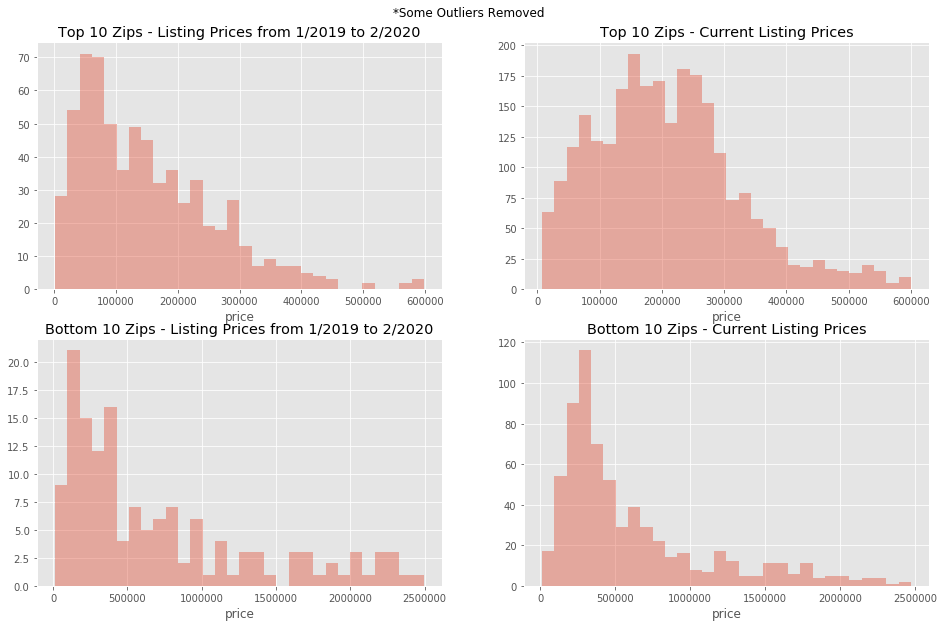

In [40]:
fig = plt.figure()
fig.suptitle("*Some Outliers Removed", y=.93)
fig.set_figheight(10)
fig.set_figwidth(16)
ax = fig.add_subplot(2, 2, 1)
top10_prices_histo2 = sns.distplot(top10_hist2['price'], kde=False, bins=30)
top10_prices_histo2.set_title('Top 10 Zips - Listing Prices from 1/2019 to 2/2020')
top10_prices_histo2.ticklabel_format(style='plain', axis='x')
ax = fig.add_subplot(2, 2, 2)
top10_prices_histo2 = sns.distplot(top10_curr2['price'], kde=False, bins=30)
top10_prices_histo2.set_title('Top 10 Zips - Current Listing Prices')
top10_prices_histo2.ticklabel_format(style='plain', axis='x')
ax = fig.add_subplot(2, 2, 3)
bot10_prices_histo2 = sns.distplot(bot10_hist2['price'], kde=False, bins=30)
bot10_prices_histo2.set_title('Bottom 10 Zips - Listing Prices from 1/2019 to 2/2020')
bot10_prices_histo2.ticklabel_format(style='plain', axis='x')
ax = fig.add_subplot(2, 2, 4)
bot10_prices_histo2 = sns.distplot(bot10_curr2['price'], kde=False, bins=30)
bot10_prices_histo2.set_title('Bottom 10 Zips - Current Listing Prices')
bot10_prices_histo2.ticklabel_format(style='plain', axis='x')
plt.show()

In [41]:
print('Descriptive statistics for the top 10 zips for historical data with some outliers removed.')
stats.describe(top10_hist2['price'])

Descriptive statistics for the top 10 zips for historical data with some outliers removed.


DescribeResult(nobs=656, minmax=(900, 599000), mean=152175.1875, variance=11926873622.033493, skewness=1.0745699177384234, kurtosis=1.211871512053711)

In [42]:
print('Descriptive statistics for the top 10 zips for current data with some outliers removed.')
stats.describe(top10_curr2['price'])

Descriptive statistics for the top 10 zips for current data with some outliers removed.


DescribeResult(nobs=2558, minmax=(7500, 599999), mean=208222.69468334637, variance=13593760021.022505, skewness=0.7226873507136865, kurtosis=0.5079209767114441)

In [43]:
print('Descriptive statistics for the bottom 10 zips for historical data with some outliers removed.')
stats.describe(bot10_hist2['price'])

Descriptive statistics for the bottom 10 zips for historical data with some outliers removed.


DescribeResult(nobs=145, minmax=(13000, 2495000), mean=710310.3172413793, variance=429302776619.2321, skewness=1.1493708104959888, kurtosis=0.2159628358219745)

In [44]:
print('Descriptive statistics for the bottom 10 zips for current data with some outliers removed.')
stats.describe(bot10_curr2['price'])

Descriptive statistics for the bottom 10 zips for current data with some outliers removed.


DescribeResult(nobs=669, minmax=(12900, 2469735), mean=607296.3258594918, variance=263872963368.5853, skewness=1.4911346175645006, kurtosis=1.514968421887418)

## Do we have equal variance between the historical and current data for Top 10 zips in positive cases?

In [45]:
print('Bartlett p-value =', stats.bartlett(top10_hist2['price'], top10_curr2['price'])[1], '\n')
print('Leven p-value =', stats.levene(top10_hist2['price'], top10_curr2['price'])[1], '\n')
print('Flinger p-value =', stats.fligner(top10_hist2['price'], top10_curr2['price'], center='mean')[1])

Bartlett p-value = 0.03713194368190194 

Leven p-value = 0.08377547055703775 

Flinger p-value = 0.12438771086376946


### Two of the tests for equal variance return p-values greater than 0.05, we'll conclude that we do have equal variance.

## Do we have equal variance between the historical and current data for Bottom 10 zips in positive cases?

In [46]:
print('Bartlett p-value =', stats.bartlett(bot10_hist2['price'], bot10_curr2['price'])[1], '\n')
print('Leven p-value =', stats.levene(bot10_hist2['price'], bot10_curr2['price'])[1], '\n')
print('Flinger p-value =', stats.fligner(bot10_hist2['price'], bot10_curr2['price'], center='mean')[1])

Bartlett p-value = 8.33124712683043e-05 

Leven p-value = 0.0011813870954148465 

Flinger p-value = 4.859029724118875e-07


### All tests return p-values lower than 0.05, so we'll conclude for our bottom 10 zips that we do not have equal variance. This means we will use Welch's 2-Sample t-Test.

## Is there a difference between the mean of the historical data for zips with the top 10 highest case counts and the mean of the current data for the zips with the top 10 highest case counts - with outliers removed?
* Null Hypothesis: The means are equal.
* Alternative Hypothesis: The means are not equal.

In [47]:
tstat, pval = stats.ttest_ind(top10_curr2['price'], top10_hist2['price'], equal_var=True)
ci = sms.CompareMeans(sms.DescrStatsW(top10_curr2['price']), sms.DescrStatsW(top10_hist2['price']))
print('p-value =', pval)
print('95% Confidence Interval -', ci.tconfint_diff(usevar='pooled'))

p-value = 3.119755397729199e-28
95% Confidence Interval - (46168.72417099467, 65926.29019569808)


In [48]:
diff = round(stats.describe(top10_curr2['price'])[2] - stats.describe(top10_hist2['price'])[2],2)
print("The mean of the real estate listings increased by $%d, during the pandemic." % diff)

The mean of the real estate listings increased by $56047, during the pandemic.


### *Interpetation:* With 95% confidence, the difference in mean listing price between the historical data and the current data of the zips with the top 10 highest counts of positiive cases is between 46,169 and 65,926 with the current data having a higher mean listing price. The small p-value tells us that we can reject the null hypothesis that the means are equal, and conclude that this difference in means is statistically significant - the mean listing price before the pandemic is not equal to the mean listing price during the pandemic for the zips with the top 10 highest counts of positiive cases. In fact, the mean increased in these zip codes!

## Is there a difference between the mean of the historical data for zips with the bottom 10 lowest case counts and the mean of the current data for the zips with the bottom 10 lowest case counts - with outliers removed?
* Null Hypothesis: The means are equal.
* Alternative Hypothesis: The means are not equal.

In [49]:
tstat, pval = stats.ttest_ind(bot10_curr2['price'], bot10_hist2['price'], equal_var=False)
ci = sms.CompareMeans(sms.DescrStatsW(bot10_curr2['price']), sms.DescrStatsW(bot10_hist2['price']))
print('p-value =', pval)
print('95% Confidence Interval -', ci.tconfint_diff(usevar='unequal'))

p-value = 0.07697971654225412
95% Confidence Interval - (-217292.81568457565, 11264.832920800705)


In [50]:
diff = round(stats.describe(bot10_curr2['price'])[2] - stats.describe(bot10_hist2['price'])[2],2)
print("The mean of the real estate listings decreased by $%d, during the pandemic." % diff)

The mean of the real estate listings decreased by $-103013, during the pandemic.


### *Interpetation:* With 95% confidence, the difference in mean listing price between the historical data and the current data of the zips with the bottom 10 lowest counts of positiive cases is between -217,293 and 11,265 with the historical data having a higher mean listing price. With the p-value above 0.05 we accept the null hypothesis that the means are equal, and conclude that this difference in means is not statistically significant - the mean listing price before the pandemic is equal to the mean listing price during the pandemic for the zips with the bottom 10 lowest counts of positiive cases. The mean of these zip codes actually decreased by 103,013. However, this test tells us that this decrease is not a statistically significant change.